In [1]:
#中文采用了清华NLP组提供的THUCNews新闻文本分类数据集的子集
data_address = '../Data_Cn/'
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from torchtext.legacy import data
from torchtext.legacy import datasets
import torchtext
import torch
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import spacy
import random
import math
import numpy as np
import matplotlib.pyplot as plt
use_cuda=torch.cuda.is_available()
device=torch.device("cuda" if use_cuda else "cpu")

SEED=1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)

torch.backends.cudnn.deterministic = True

In [3]:
import pandas as pd
train_data = pd.read_csv(data_address+'cnews.train.txt',sep='\t',names=['label','content'])
test_data = pd.read_csv(data_address+'cnews.test.txt',sep='\t',names=['label','content'])
dev_data = pd.read_csv(data_address+'cnews.val.txt',sep='\t',names=['label','content'])


In [4]:
train_data.head()

,label,content
0,体育,马晓旭意外受伤让国奥警惕 无奈大雨格外青睐殷家军记者傅亚雨沈阳报道 来到沈阳，国奥队依然没有...
1,体育,商瑞华首战复仇心切 中国玫瑰要用美国方式攻克瑞典多曼来了，瑞典来了，商瑞华首战求3分的信心也...
2,体育,冠军球队迎新欢乐派对 黄旭获大奖张军赢下PK赛新浪体育讯12月27日晚，“冠军高尔夫球队迎新...
3,体育,辽足签约危机引注册难关 高层威逼利诱合同笑里藏刀新浪体育讯2月24日，辽足爆发了集体拒签风波...
4,体育,揭秘谢亚龙被带走：总局电话骗局 复制南杨轨迹体坛周报特约记者张锐北京报道 谢亚龙已经被公安...


In [5]:
train_data.info

<bound method DataFrame.info of       label                                            content
0        体育  马晓旭意外受伤让国奥警惕 无奈大雨格外青睐殷家军记者傅亚雨沈阳报道 来到沈阳，国奥队依然没有...
1        体育  商瑞华首战复仇心切 中国玫瑰要用美国方式攻克瑞典多曼来了，瑞典来了，商瑞华首战求3分的信心也...
2        体育  冠军球队迎新欢乐派对 黄旭获大奖张军赢下PK赛新浪体育讯12月27日晚，“冠军高尔夫球队迎新...
3        体育  辽足签约危机引注册难关 高层威逼利诱合同笑里藏刀新浪体育讯2月24日，辽足爆发了集体拒签风波...
4        体育  揭秘谢亚龙被带走：总局电话骗局 复制南杨轨迹体坛周报特约记者张锐北京报道  谢亚龙已经被公安...
...     ...                                                ...
49995    财经  打好投资的决胜局□国泰基金 阿邰就长期而言，资产配置占投资成功与否的决定因素高达90%以上。...
49996    财经  昔明星基金今年首月负收益 QDII成今年胸闷基金□晨报记者 陈重博2009年以来，所有偏股型...
49997    财经  沪基指全周大涨8.25% 创两个月最大周涨幅全景网2月6日讯 受到A股市场牛年高歌猛进影响，...
49998    财经  沪基指半日涨2.01% 两市封基近乎全线上扬全景网2月6日讯 沪深基金指数周五早盘大幅收高，...
49999    财经  牛年第一月 开基抬头券商集合理财掉队每经记者 于春敏在金融危机的淫威之下，2008年，全球资...

[50000 rows x 2 columns]>

In [6]:
from collections import Counter
Counter(list(train_data.label))

Counter({'体育': 5000,
         '娱乐': 5000,
         '家居': 5000,
         '房产': 5000,
         '教育': 5000,
         '时尚': 5000,
         '时政': 5000,
         '游戏': 5000,
         '科技': 5000,
         '财经': 5000})

# 分词

In [7]:
from transformers import BertTokenizer
tokenizer=BertTokenizer.from_pretrained('../utils/bert-base-chinese')

In [8]:
#分词单个例子
token=tokenizer.tokenize("我喜欢打篮球")

print(token)
indexes=tokenizer.convert_tokens_to_ids(token)

print(indexes)

['我', '喜', '欢', '打', '篮', '球']
[2769, 1599, 3614, 2802, 5074, 4413]


In [9]:
#bert特殊token
cls_token=tokenizer.cls_token
sep_token=tokenizer.sep_token
pad_token=tokenizer.pad_token
unk_token=tokenizer.unk_token

print(cls_token,sep_token,pad_token,unk_token)
cls_token_id=tokenizer.cls_token_id
sep_token_id=tokenizer.sep_token_id
pad_token_id=tokenizer.pad_token_id
unk_token_id=tokenizer.unk_token_id

print(cls_token_id,sep_token_id, pad_token_id, unk_token_id)


[CLS] [SEP] [PAD] [UNK]
101 102 0 100


In [10]:
#长度限制
max_input_length = tokenizer.max_model_input_sizes['bert-base-chinese']
#但是这个太长了，改128吧
print(max_input_length)
max_input_length = 128

512


# 数据集准备

## Field

In [11]:
TEXT=torchtext.legacy.data.Field(batch_first=True,use_vocab=False,tokenize=tokenizer.encode,
                fix_length=max_input_length,
                init_token=cls_token_id,
                eos_token=sep_token_id,
                pad_token=pad_token_id,
                unk_token=unk_token_id)

LABEL=torchtext.legacy.data.LabelField(dtype=torch.long,use_vocab=False)

In [12]:
train_dataset,dev_dataset,test_dataset = torchtext.legacy.data.TabularDataset.splits(
      path=data_address,  #文件存放路径
      format='tsv',   #文件格式
      skip_header=False,  #是否跳过表头，我这里数据集中没有表头，所以不跳过
      train='train_data.tsv',  
      validation='test_data.tsv',
      test='dev_data.tsv',    
      fields=[('label',LABEL),('content',TEXT)] # 定义数据对应的表头
  )

In [13]:
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(dev_dataset)}")
print(f"Number of testing examples: {len(test_dataset)}")

Number of training examples: 50000
Number of validation examples: 10000
Number of testing examples: 5000


In [14]:
print(vars(train_dataset.examples[3]))

{'label': '0', 'content': [101, 6808, 6639, 5041, 5276, 1314, 3322, 2471, 3800, 1085, 7410, 1068, 7770, 2231, 2014, 6873, 1164, 6430, 1394, 1398, 5010, 7027, 5966, 1143, 3173, 3857, 860, 5509, 6380, 123, 3299, 8125, 3189, 8024, 6808, 6639, 4255, 1355, 749, 7415, 860, 2867, 5041, 7599, 3797, 8024, 679, 5041, 1394, 1398, 8024, 6808, 6639, 4638, 3800, 1085, 7309, 7579, 2218, 2523, 3475, 2797, 511, 680, 2518, 2399, 671, 3416, 8024, 6808, 6639, 2600, 833, 6878, 1168, 3800, 1085, 1314, 3322, 8024, 852, 3297, 1400, 6963, 3221, 6649, 6649, 3058, 3058, 1765, 5885, 3921, 6814, 1068, 511, 791, 2399, 8024, 6808, 2123, 2131, 6817, 7415, 1730, 3836, 6897, 1762, 936, 727, 6956, 4638, 7942, 1998, 4908, 741, 1469, 1199, 2600, 7387, 6241, 1762, 3862, 1811, 6901, 1168, 4638, 679, 1398, 754, 2518, 2399, 4638, 2850, 2834, 511, 6821, 3613, 1343, 5041, 5276, 8024, 6808, 6639, 4638, 1394, 1398, 3221, 1906, 1358, 6574, 4542, 4638, 4193, 4157, 511, 800, 812, 4500, 758, 2399, 3299, 5959, 8212, 1039, 4638, 1394, 

# vocab

In [15]:
LABEL.build_vocab(train_dataset)

# iterator

In [16]:
BATCH_SIZE = 16

train_iter, valid_iter, test_iter=data.BucketIterator.splits(
    (train_dataset, dev_dataset, test_dataset),
    sort=False,
    batch_size=BATCH_SIZE,
    device=device)

In [17]:
# 小测试
for (content, label) in train_iter:
    print(content)
    print(label)
    break


tensor([[ 101,  101,  711,  ..., 8024, 8149,  102],
        [ 101,  101, 2199,  ...,    0,    0,    0],
        [ 101,  101, 1282,  ...,  671, 6762,  102],
        ...,
        [ 101,  101, 3330,  ..., 2501, 6496,  102],
        [ 101,  101,  686,  ..., 1398, 5528,  102],
        [ 101,  101,  517,  ...,  510, 7032,  102]], device='cuda:0')
tensor([4, 2, 0, 0, 7, 6, 2, 0, 7, 2, 1, 0, 4, 1, 6, 1], device='cuda:0')


# 模型

In [18]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        
        self.encoder = BertForSequenceClassification.from_pretrained('../utils/bert-base-chinese',num_labels=10)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

# 训练

In [19]:
# 保存模型参数和训练指标
def save_checkpoint(save_path, model,valid_loss):
    if save_path == None:
        return None
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path) 
    print(f'Model saved to ==> {save_path}')
def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']
def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [20]:
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = './model_bert_cn',
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (content, label) in train_loader:
            labels = label.type(torch.LongTensor)           
            labels = labels.to(device)
            titletext = content.type(torch.LongTensor)  
            titletext = titletext.to(device)
            output = model(titletext, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (content, label) in valid_loader:
                        labels = label.type(torch.LongTensor)           
                        labels = labels.to(device)
                        titletext = content.type(torch.LongTensor)  
                        titletext = titletext.to(device)
                        output = model(titletext, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [21]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)



Some weights of the model checkpoint at ../utils/bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model chec

In [22]:
train(model=model, optimizer=optimizer)

Epoch [1/5], Step [1562/15625], Train Loss: 0.1984, Valid Loss: 0.1296
Model saved to ==> ./model_bert_cn/model.pt
Model saved to ==> ./model_bert_cn/metrics.pt
Epoch [1/5], Step [3124/15625], Train Loss: 0.1025, Valid Loss: 0.1241
Model saved to ==> ./model_bert_cn/model.pt
Model saved to ==> ./model_bert_cn/metrics.pt
Epoch [2/5], Step [4686/15625], Train Loss: 0.0638, Valid Loss: 0.1040
Model saved to ==> ./model_bert_cn/model.pt
Model saved to ==> ./model_bert_cn/metrics.pt
Epoch [2/5], Step [6248/15625], Train Loss: 0.0614, Valid Loss: 0.1454
Epoch [3/5], Step [7810/15625], Train Loss: 0.0378, Valid Loss: 0.1190
Epoch [3/5], Step [9372/15625], Train Loss: 0.0431, Valid Loss: 0.1333
Epoch [4/5], Step [10934/15625], Train Loss: 0.0239, Valid Loss: 0.1712
Epoch [4/5], Step [12496/15625], Train Loss: 0.0319, Valid Loss: 0.1466
Epoch [5/5], Step [14058/15625], Train Loss: 0.0227, Valid Loss: 0.2098
Epoch [5/5], Step [15620/15625], Train Loss: 0.0243, Valid Loss: 0.1537
Model saved to =

Model loaded from <== ./model_bert_cn/metrics.pt


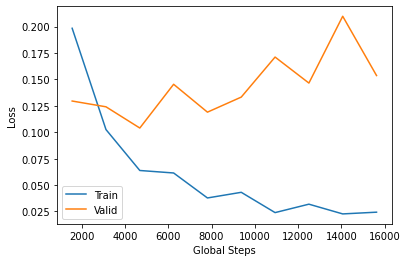

In [26]:

destination_folder = './model_bert_cn'
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 